# SMYLE & CLM5-TRENDY TWS perfect prediction skill

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from distributed import wait

%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Data I/O using Dask

### Create Dask Cluster

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='P93300041',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
client

<Client: 'tcp://10.12.1.3:39192' processes=0 threads=0, memory=0 B>

### Read in CLM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [5]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_mid(ds0,'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [6]:
# SMYLE-NOV TWS data
# process all 20 ensemble members, all start dates dates from 1970-2018:
# these only need to be defined once, with io for each initialized month handled below
field = 'TWS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.clm2.h0.'
filetemplate = datadir+casename+'/lnd/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
print(filetemplate)
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018

/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.????-MM.EEE/lnd/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.????-MM.EEE.clm2.h0.TWS.*.nc


In [7]:
%%time
startmonth = 11
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle11 data set = '+str(smyle11.nbytes/1e9)+ ' GB') #GB

smyle11 data set = 3.468170792 GB
CPU times: user 49.7 s, sys: 20.8 s, total: 1min 10s
Wall time: 1min 46s


In [8]:
%%time
# why not persist here (but persist also breaks the code...)?  
smyle11 = smyle11.load()
_ = wait(smyle11)

CPU times: user 58.7 s, sys: 7.19 s, total: 1min 5s
Wall time: 1min 5s


In [9]:
%%time
# SMYLE-FEB TS data
# process all 20 ensemble members, Feb dates from 1970-2018:
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle02 data set = '+str(smyle02.nbytes/1e9)+ ' GB') #GB

smyle02 data set = 3.468170792 GB
CPU times: user 49.8 s, sys: 20.7 s, total: 1min 10s
Wall time: 1min 42s


In [10]:
%%time
smyle02=smyle02.load()
_ = wait(smyle02)

CPU times: user 56.6 s, sys: 6.16 s, total: 1min 2s
Wall time: 1min 2s


In [11]:
%%time
# SMYLE-MAY TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('data set = '+str(smyle05.nbytes/1e9)+ ' GB') #GB

data set = 3.468170792 GB
CPU times: user 50.6 s, sys: 21.4 s, total: 1min 11s
Wall time: 1min 42s


In [12]:
%%time 
smyle05 = smyle05.load() 
_ = wait(smyle05)

CPU times: user 58.6 s, sys: 6.23 s, total: 1min 4s
Wall time: 1min 4s


In [13]:
%%time
# SMYLE-AUG TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle08 data set = '+str(smyle08.nbytes/1e9)+ ' GB') #GB

smyle08 data set = 3.468170792 GB
CPU times: user 49.4 s, sys: 20.5 s, total: 1min 9s
Wall time: 1min 42s


In [14]:
%%time
smyle08=smyle08.persist()
_ = wait(smyle08)

CPU times: user 48.3 s, sys: 848 ms, total: 49.1 s
Wall time: 48.8 s


### DataArrays are manageable size now (and in memory), so release Dask cluster 

### Get results from CLM5 SMYLE-TRENDY for potential predictability
/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/

In [7]:
# This could go to utils
def time_set_mid(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with midpoints of
    ds[time_name].attrs['bounds'], if bounds attribute exists.
    Except for time_name, the returned Dataset is a copy of ds2.
    The copy is deep or not depending on the argument deep.
    """

    ds_out = ds.copy(deep)

    if "bounds" not in ds[time_name].attrs:
        return ds_out

    tb_name = ds[time_name].attrs["bounds"]
    tb = ds[tb_name]
    bounds_dim = next(dim for dim in tb.dims if dim != time_name)

    # Use da = da.copy(data=...), in order to preserve attributes and encoding.

    # If tb is an array of datetime objects then encode time before averaging.
    # Do this because computing the mean on datetime objects with xarray fails
    # if the time span is 293 or more years.
    #     https://github.com/klindsay28/CESM2_coup_carb_cycle_JAMES/issues/7
    if tb.dtype == np.dtype("O"):
        units = "days since 0001-01-01"
        calendar = "noleap"
        tb_vals = cftime.date2num(ds[tb_name].values, units=units, calendar=calendar)
        tb_mid_decode = cftime.num2date(
            tb_vals.mean(axis=1), units=units, calendar=calendar
        )
        ds_out[time_name] = ds[time_name].copy(data=tb_mid_decode)
    else:
        ds_out[time_name] = ds[time_name].copy(data=tb.mean(bounds_dim))

    return ds_out

In [30]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/'
fin = 'smyle_Transient.clm2.h0.'+field+'.185001-201812.nc'
#ds_clm = time_set_mid(xr.open_dataset(obs_dir+fin,decode_times=True),'time')
ds_clm = xr.open_dataset(obs_dir+fin,decode_times=False)
clm_montime_vals = [cftime.DatetimeNoLeap(1850+year, 1+month, 15) for year in range(169) for month in range(12)]
ds_clm['time'] = clm_montime_vals
ds_clm = ds_clm.sel(time=slice('1960','2018'))
#ds_clm = = ds_clm.load() 
#_ = wait(ds_clm)

ds_clm.TWS

<xarray.DataArray 'TWS' (time: 708, lat: 192, lon: 288)>
[39149568 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00
Attributes:
    long_name:     total water storage
    units:         mm
    cell_methods:  time: mean

In [32]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_hadisst.time)
hadisst_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])
ds_hadisst = ds_hadisst.sel(time=slice("1960","2020"))
ds_hadisst.sst

<xarray.DataArray 'sst' (time: 732, latitude: 180, longitude: 360)>
array([[[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
...
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * time       (time) object 1960-01-15 00:00:00 ... 2020-12-15 00:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

### Compute OBS seasonal averages

In [33]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [34]:
clm_ts_seas = obs_convert_mon_to_seas(ds_clm.TWS,'TWS')

TypeError: 'DataArrayGroupBy' object is not subscriptable

In [21]:
#ersstv5_ts_seas = obs_convert_mon_to_seas(ds_ersstv5.sst,'TS')
cal.mon_to_seas(ds_clm.TWS).groupby('time.month')[1]

TypeError: 'DataArrayGroupBy' object is not subscriptable

In [19]:
hadisst_ts_seas = obs_convert_mon_to_seas(ds_hadisst.sst,'TS')

TypeError: 'DataArrayGroupBy' object is not subscriptable

In [27]:
def merge_obs(da1,da2):
    return da1.fillna(da2)

In [28]:
# merged CRU/HadISST
#cruhadisst = merge_obs_camgrid(cru_ts_seas_rg,hadisst_ts_seas_rg,fv1_landmask.LANDFRAC,0.5)
cruhadisst = merge_obs(cru_ts_seas_rg,hadisst_ts_seas_rg)

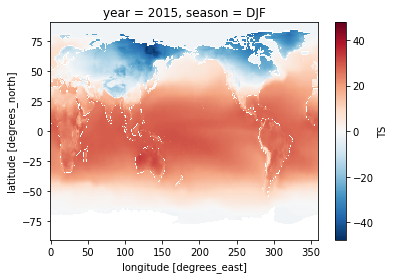

In [29]:
cruhadisst.isel(season=0).sel(year=2015).plot();

In [30]:
## convert OBS to anomalies from 1972-2017
cruhadisst = cruhadisst - cruhadisst.sel(year=slice(1972,2017)).mean('year')

# Anomaly Correlation Plots

In [31]:
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11,smyle11.time,1972,2017)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02,smyle02.time,1972,2017)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05,smyle05.time,1972,2017)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08,smyle08.time,1972,2017)

In [62]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_corr_byseas(mod_da,mod_time,obs_da,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [63]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11.time,cruhadisst)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11.time,cruhadisst)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02.time,cruhadisst)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05.time,cruhadisst)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08.time,cruhadisst)

CPU times: user 17.4 s, sys: 6.84 s, total: 24.2 s
Wall time: 24 s


CPU times: user 46.9 s, sys: 202 ms, total: 47.1 s
Wall time: 47 s


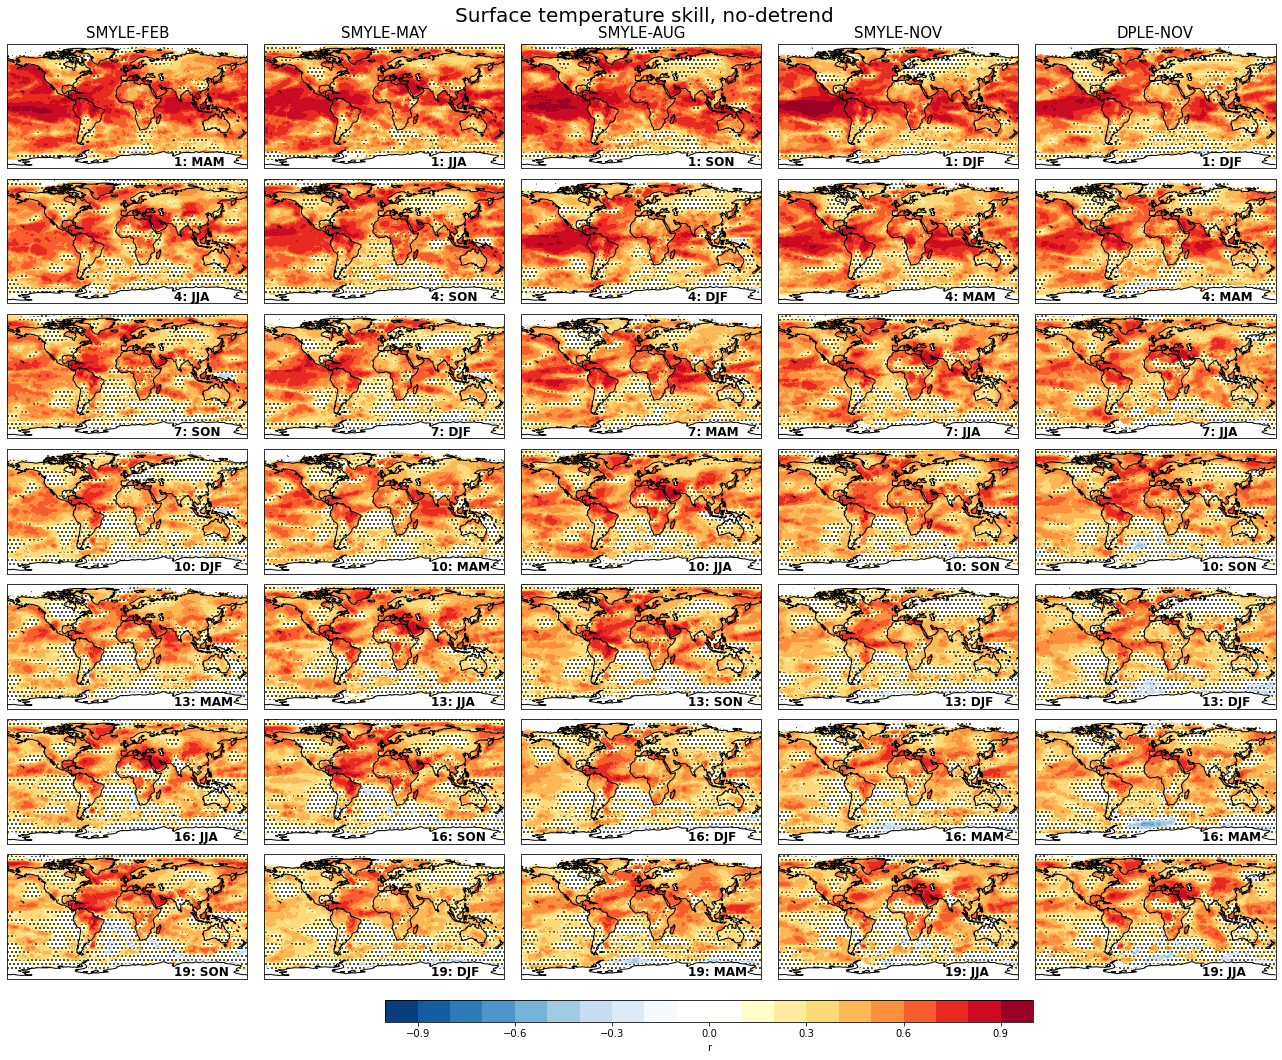

In [65]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')

### Test Significance Hatching using correlation p-values

CPU times: user 1.37 s, sys: 5.59 ms, total: 1.37 s
Wall time: 1.38 s


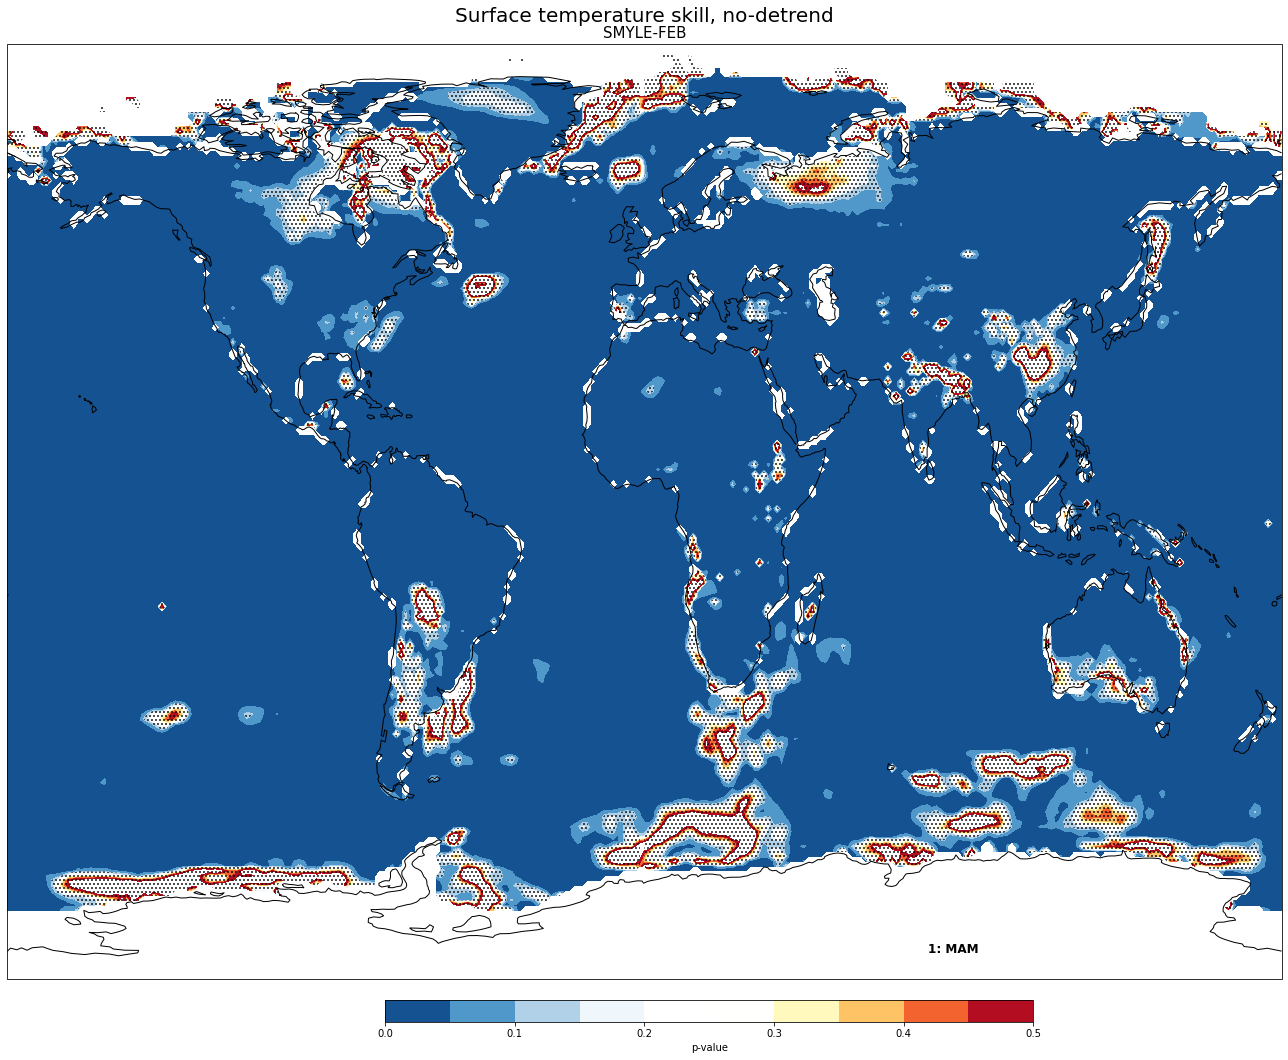

In [57]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...','...'], alpha=0.)
    ldstr = str(i+1) + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle('Surface temperature skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [83]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11.time,cruhadisst,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11.time,cruhadisst,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02.time,cruhadisst,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05.time,cruhadisst,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08.time,cruhadisst,detrend=True)

CPU times: user 38.7 s, sys: 8.94 s, total: 47.6 s
Wall time: 45.6 s


CPU times: user 1min 9s, sys: 195 ms, total: 1min 9s
Wall time: 1min 9s


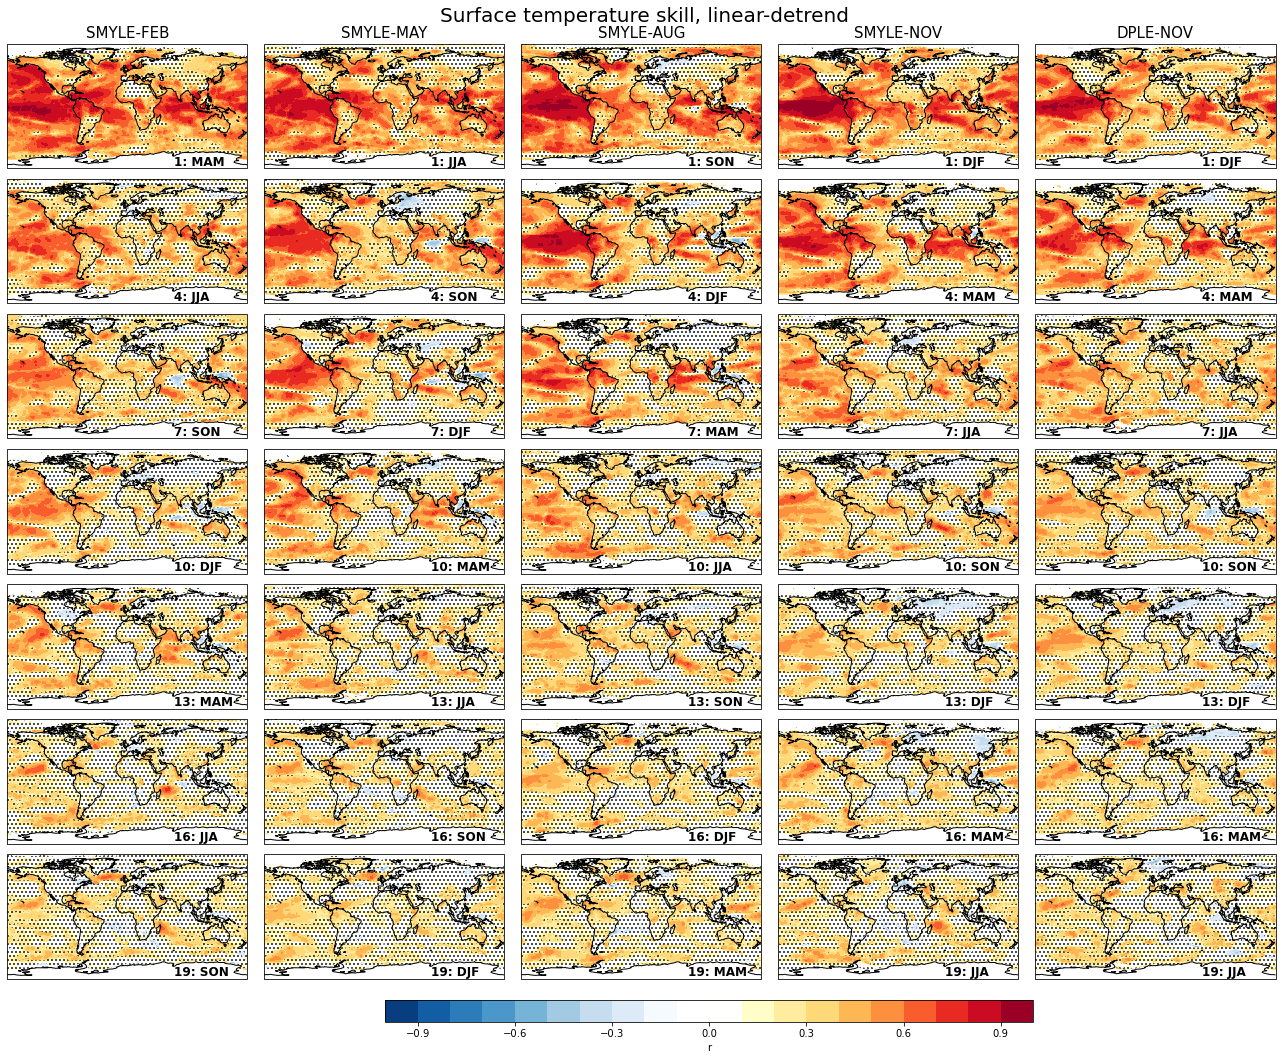

In [84]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_1a.png')

### Test skill sensitivity to OBS dataset: use HadCRU5-ERSSTv5

In [68]:
# Xian Wu's merged HadCRU5-ERSSTv5 data on CAM fv1 grid
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_obs = xr.open_dataset(obs_dir+'mon/merge_ocean_land_data/merge-ts-sst-obsdata-HadCRUT5-ERSSTv5-1900-2020.nc')
nt = np.size(ds_obs.time)
obs_montime_vals = [cftime.DatetimeNoLeap(1900+year, 1+month, 15) for year in range(121) for month in range(12)]
ds_obs['time'] = obs_montime_vals
ds_obs = ds_obs.sel(time=slice("1960","2020"))

In [69]:
obs_ts_seas = obs_convert_mon_to_seas(ds_obs.ts,'TS').TS

In [70]:
## convert OBS to anomalies from 1972-2017
obs_ts_seas = obs_ts_seas - obs_ts_seas.sel(year=slice(1972,2017)).mean('year')

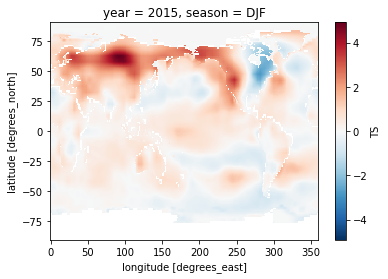

In [71]:
obs_ts_seas.isel(season=0).sel(year=2015).plot();

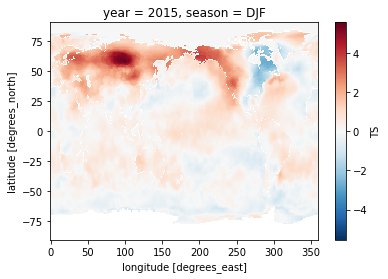

In [72]:
cruhadisst.isel(season=0).sel(year=2015).plot();

In [73]:
## need to correct obs grid which is slightly off:
obs_ts_seas = obs_ts_seas.assign_coords(lat=("lat",smyle11.lat.data)).assign_coords(lon=("lon",smyle11.lon.data))

In [81]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom.TS,smyle11.time,obs_ts_seas,detrend=True)
dple11_corr = leadtime_corr_byseas(dple11_anom.TS,dple11.time,obs_ts_seas,detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom.TS,smyle02.time,obs_ts_seas,detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom.TS,smyle05.time,obs_ts_seas,detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom.TS,smyle08.time,obs_ts_seas,detrend=True)

CPU times: user 37.8 s, sys: 9.14 s, total: 47 s
Wall time: 44.9 s


CPU times: user 44.9 s, sys: 133 ms, total: 45.1 s
Wall time: 44.9 s


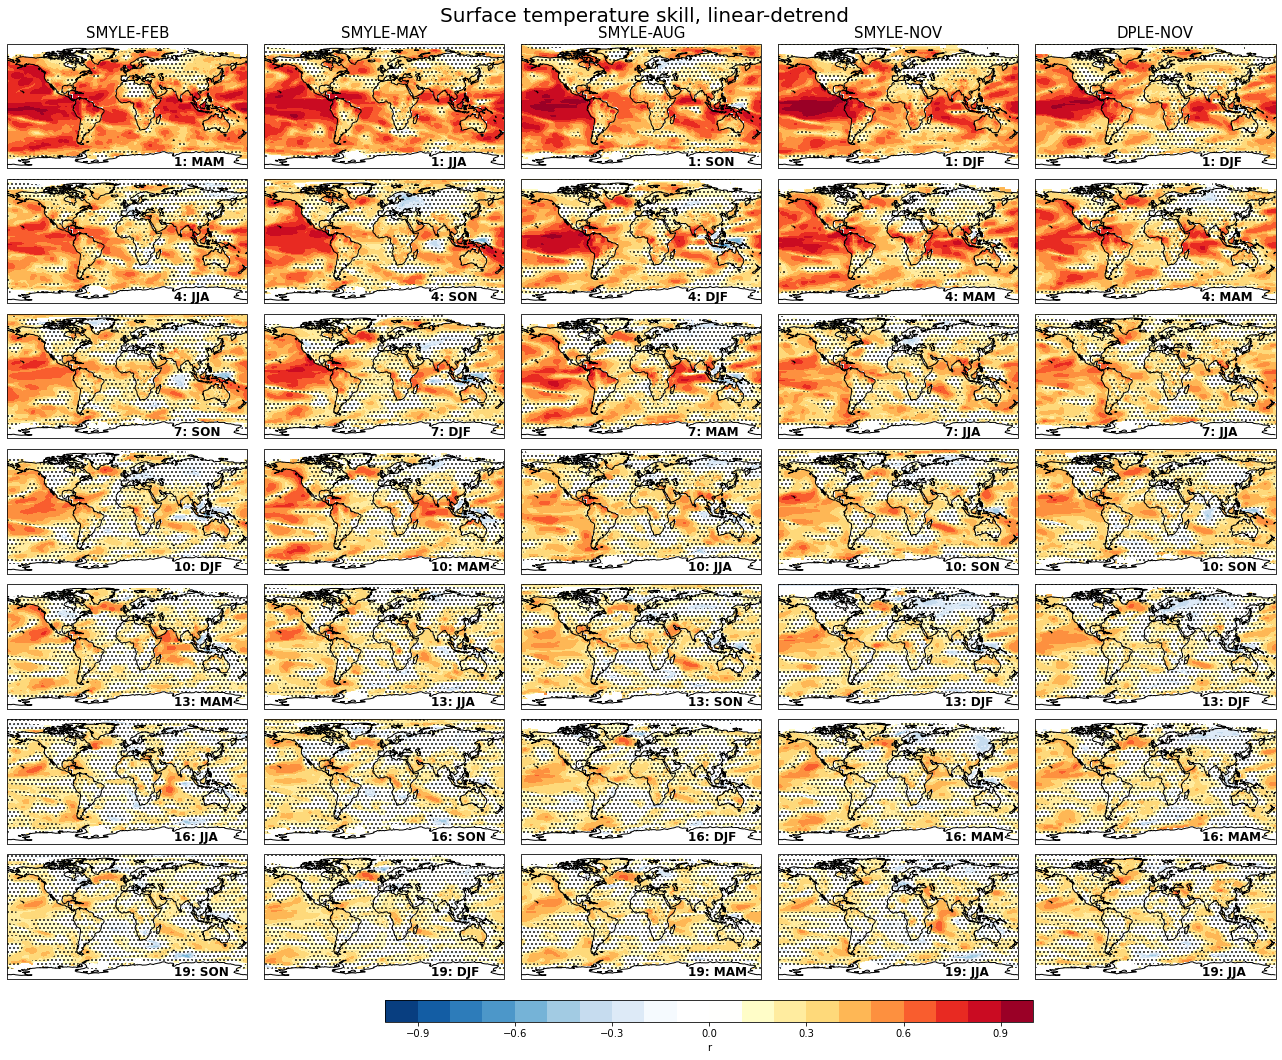

In [82]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,15))
nrows=7
ncols=5

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV','DPLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*5+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*5+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*5+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*5+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax5,cntr5 = maps.map_contourf_global_subplot(fig, dple11_corr.corr.isel(L=i), dple11_corr.lon, dple11_corr.lat,
                                       ci,cmin,cmax,colstr[4],lstr,rstr,nrows,ncols,i*5+5,proj)
    ax5.contourf(dple11_corr.lon, dple11_corr.lat,dple11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(dple11_corr.isel(L=i).season.values)
    ax5.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_1b.png')